# 0 Setup

In [36]:
# importing all required packages at the start of the notebook
import IPython
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
os.getcwd() #Get the working directory

'/home/jovyan/assignments/FunGut-Project'

In [3]:
data_dir = "/home/jovyan/assignments/FunGut-Project" #Store the folder's path

# 1 Importing the data

In [4]:
# Getting our data from the polybox:
!wget -O fungut_forward_reads.qza "https://polybox.ethz.ch/index.php/s/uV06vmm96ZzB5eM/download/fungut_forward_reads.qza"
!wget -O fungut_sample_metadata.tsv "https://polybox.ethz.ch/index.php/s/CA76kKFC9FApqpR/download/fungut_metadata.tsv"

--2025-10-06 15:23:31--  https://polybox.ethz.ch/index.php/s/uV06vmm96ZzB5eM/download/fungut_forward_reads.qza
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712595535 (680M) [application/octet-stream]
Saving to: ‘fungut_forward_reads.qza’

fungut_forward_read 100%[===================>] 679.58M   277MB/s    in 2.5s    

2025-10-06 15:23:34 (277 MB/s) - ‘fungut_forward_reads.qza’ saved [712595535/712595535]

--2025-10-06 15:23:35--  https://polybox.ethz.ch/index.php/s/CA76kKFC9FApqpR/download/fungut_metadata.tsv
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18798 (18K) [application/octet-stream]
Saving to: ‘fungut_sample_metadata.tsv’

fungut_sample_metad 100%[===================>]  18.3

In [5]:
# To check that our files are in the right place:
qza_file = f"{data_dir}/fungut_forward_reads.qza" #Store the sequences file
tsv_file = f"{data_dir}/fungut_sample_metadata.tsv" #Store the sample metadata file
print("File exists?", os.path.exists(qza_file), os.path.exists(tsv_file))

File exists? True True


# 3 Feature table construction

## 3.1 First overview of our sample and quality score assessment 

In [6]:
!qiime demux summarize \
  --i-data fungut_forward_reads.qza \
  --o-visualization demux-summary.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: demux-summary.qzv


In [7]:
Visualization.load(f"{data_dir}/demux-summary.qzv")

<visualization: Visualization uuid: 45dfd4ba-98b9-44a3-9dc3-44135fcdc1d3>

The mean length of our reads is 151 nts. We can see that the quality of our reads stays quite high, even at the end of the sequences (mean quality score ~38 at the position 151).

## 3.2 Denoizing and creation of ASVs

In [8]:
! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir/fungut_forward_reads.qza \
    --p-trunc-len 0 \
    --p-n-threads 3 \
    --o-table $data_dir/dada2_table_no_trunc.qza \
    --o-representative-sequences $data_dir/dada2_rep_set_no_trunc.qza \
    --o-denoising-stats $data_dir/dada2_stats_no_trunc.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C


First I tried to put 150 nts as trunc-len, but this disgarded too much sequences. I don't want to put the truncating lenght lower, because we will loose a lot of information on the sequences. As ITS have usually very different length, and that the mean quality of our reads was good, I want to keep all of them. However, after denoizing I want to do a step in order to remove the sequences that are too rare and the ones that come up in too few samples, in order to avoid too much noise in further downstream analysis:

In [9]:
! qiime feature-table filter-features \
  --i-table $data_dir/dada2_table_no_trunc.qza \
  --p-min-frequency 10 \
  --p-min-samples 2 \
  --o-filtered-table $data_dir/dada2_table.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C
R[write to console]: 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/q2cli/util.py", line 275, in get_plugin_manager
    return qiime2.sdk.PluginManager.reuse_existing()
  File "/opt/conda/lib/python3.10/site-packages/qiime2/sdk/plugin_manager.py", line 58, in reuse_existing
    raise UninitializedPluginManagerError
qiime2.sdk.plugin_manager.UninitializedPluginManagerError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/q2cli/click/type.py", line 117, in _convert_input
    result, error = q2cli.util._load_input(value)
  F

Now we have filtered all features that have a frequencies smaller than 10% across all samples, as well as features present in only one sample. Now that it's done, I will update the list of sequences so they match.

In [10]:
! qiime feature-table filter-seqs \
  --i-data $data_dir/dada2_rep_set_no_trunc.qza \
  --i-table $data_dir/dada2_table.qza \
  --o-filtered-data $data_dir/dada2_rep_set.qza

^C

Aborted!


Now that our denoizing and filtering is done, we can look at what the result it. Let's start with the denoizing statistics (so here nothing is filtered yet):

In [11]:
! qiime metadata tabulate \
    --m-input-file $data_dir/dada2_stats_no_trunc.qza \
    --o-visualization $data_dir/dada2_stats_no_trunc.qzv

^C

Aborted!


In [12]:
Visualization.load(f"{data_dir}/dada2_stats_no_trunc.qzv")

<visualization: Visualization uuid: 5e210916-78b0-4341-b097-8a76430e936a>

Eyeballing it the statistics look good, we don't loose to many sequences.

Now we are going to visualize the sequences:

In [13]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/dada2_rep_set.qza \
    --o-visualization $data_dir/dada2_rep_set.qzv

^C

Aborted!


In [14]:
Visualization.load(f"{data_dir}/dada2_rep_set.qzv")

<visualization: Visualization uuid: 32ff7640-801a-4dd5-bc1b-e17d6a81b1aa>

We can see that we have 145 unique features (=ASVs) after filtering.

Finally, we are going to create a feature table with the information of our sequences and the sample metadata:

In [15]:
! qiime feature-table summarize \
    --i-table $data_dir/dada2_table.qza \
    --m-sample-metadata-file $data_dir/fungut_sample_metadata.tsv \
    --o-visualization $data_dir/dada2_table.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C

Aborted!


In [16]:
Visualization.load(f"{data_dir}/dada2_table.qzv")

<visualization: Visualization uuid: f07aed9f-0a03-4d1d-84d7-abb553e535dd>

Bonus: We can compare this table that we just made that contains the information of the filtered features (with >=10% of frequency and presence in >= 2 samples) with a table created with all the sequences prior to filtering:

In [17]:
! qiime feature-table summarize \
    --i-table $data_dir/dada2_table_no_trunc.qza \
    --m-sample-metadata-file $data_dir/fungut_sample_metadata.tsv \
    --o-visualization $data_dir/dada2_table_no_trunc.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C

Aborted!


In [18]:
Visualization.load(f"{data_dir}/dada2_table_no_trunc.qzv")

<visualization: Visualization uuid: c01db64b-b707-43ff-9e3d-8ef30c80ffff>

Thing is that with my filter I did remove a lot of special features that seemed either to appear in only one sample, or to be at a less than 10% frequency. I don't know how to decide if that's good or not.

# Analysis of the sample metadata

In [46]:
sample_metadata = pd.read_csv("fungut_sample_metadata.tsv", sep="\t", na_values=["Not provided"])
sample_metadata.head()

,ID,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
0,ERR5327198,USA,TN,36.1,-86.8,female,67.0,152.0,41.0,17.75,Omnivore,I do not have this condition,No
1,ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,I do not have this condition,I was diagnosed with gluten allergy (anti-glut...
2,ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad
3,ERR5327282,United Kingdom,NaN,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,I do not have this condition,No
4,ERR5327284,United Kingdom,NaN,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,I do not have this condition,No


## Specific questions from our FunGut guidelines

### Sex ratio

Text(0.5, 0.98, 'Sex ratio')

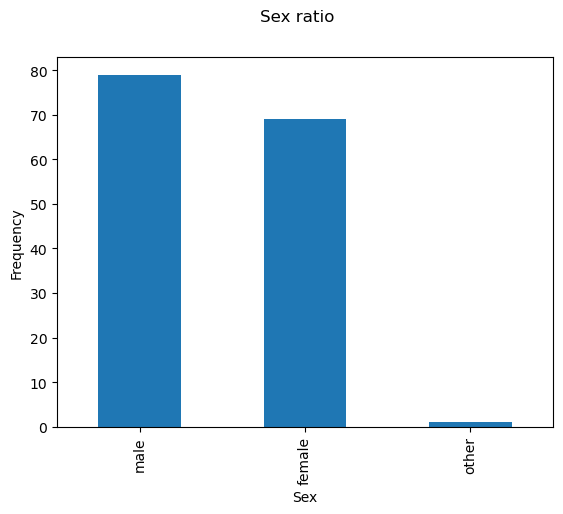

In [47]:
sample_metadata["sex_sample"].value_counts().plot(kind="bar")
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.suptitle("Sex ratio")

### Distribution of age, height and weight

Text(0.5, 0.98, 'Age distribution')

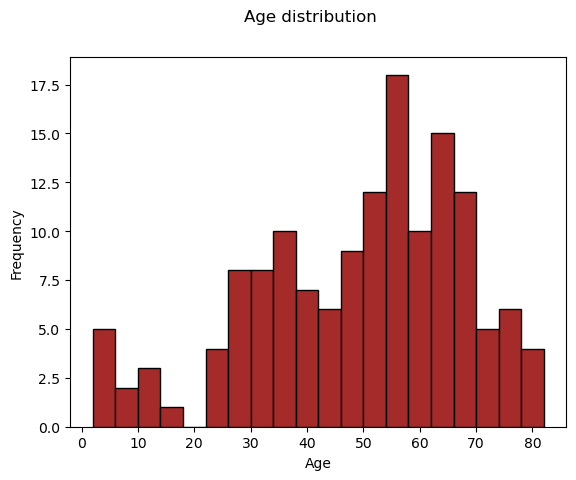

In [69]:
sample_metadata["age_years_sample"].plot.hist(bins=20, edgecolor="black", color="brown")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.suptitle("Age distribution")

We might want to make age groups for the rest of our analysis. However I don't know how we should divid it, as the microbiome changes with age, so just dividing it might not be a good idea. Doing this we would have to check that our groups have not too different numbers of samples I guess.

Text(0.5, 0.98, 'Height distribution')

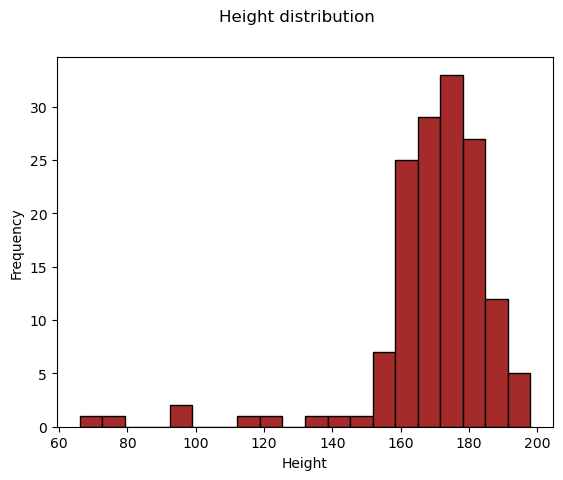

In [71]:
sample_metadata["height_cm_sample"].plot.hist(bins=20, edgecolor="black", color="brown")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.suptitle("Height distribution")

The tiny ones are probably also the young ones

Text(0.5, 0.98, 'Weight distribution')

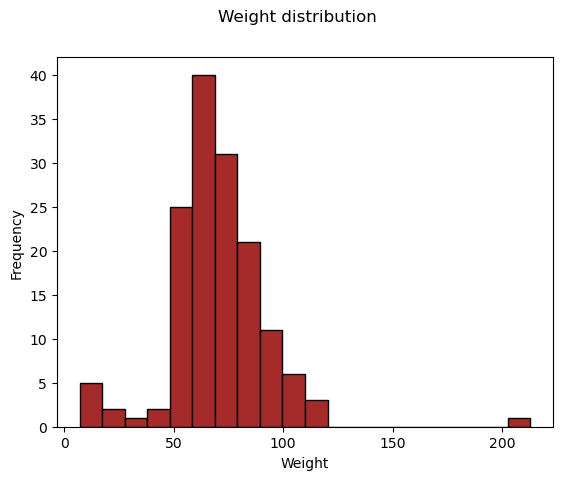

In [72]:
sample_metadata["weight_kg_sample"].plot.hist(bins=20, edgecolor="black", color="brown")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.suptitle("Weight distribution")

Probably most of them have a link with age/sex. BMI is a good indicator

### Types of diet

Text(0.5, 0.98, 'Types of diet')

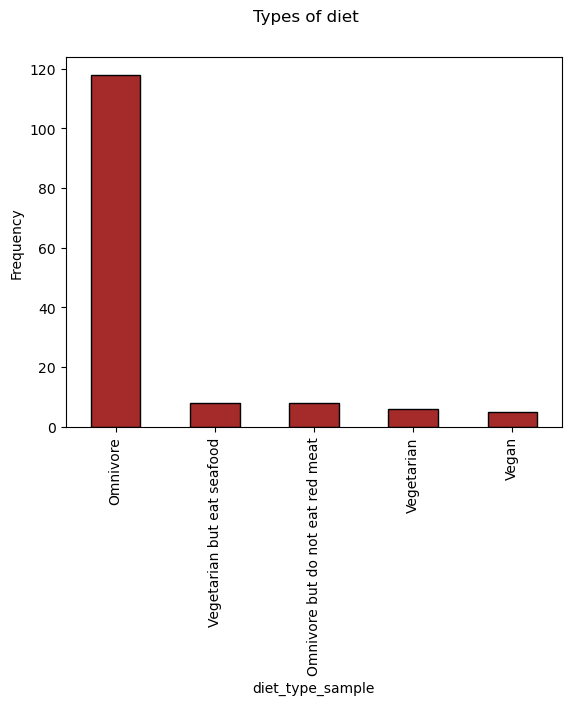

In [81]:
sample_metadata["diet_type_sample"].value_counts().plot(kind="bar", edgecolor="black", color="brown")
plt.ylabel("Frequency")
plt.suptitle("Types of diet")

### Diseases

Information about inflammatory bowel disease (IBD) and celiac disease (CD) were collected in the sample metadata.

Text(0.5, 0.98, 'IBD prevalence')

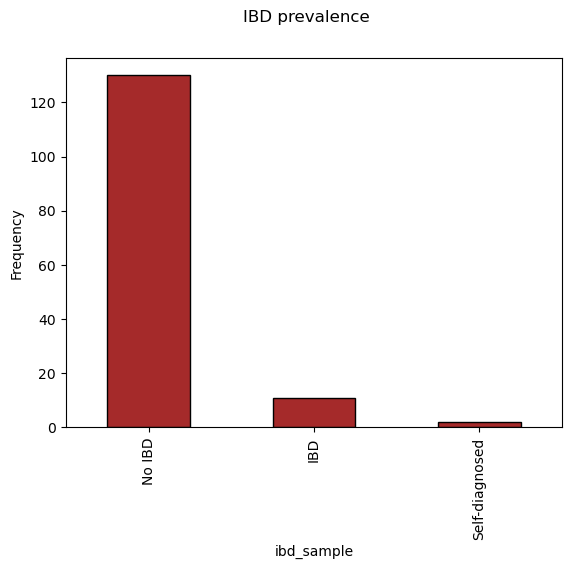

In [89]:
sample_metadata.replace({"ibd_sample":"I do not have this condition"}, "No IBD", inplace=True)
sample_metadata.replace({"ibd_sample":"Diagnosed by a medical professional (doctor, physician assistant)"}, "IBD", inplace=True)
sample_metadata["ibd_sample"].value_counts().plot(kind="bar", edgecolor="black", color="brown")
plt.ylabel("Frequency")
plt.suptitle("IBD prevalence")

Text(0.5, 0.98, 'CD prevalence')

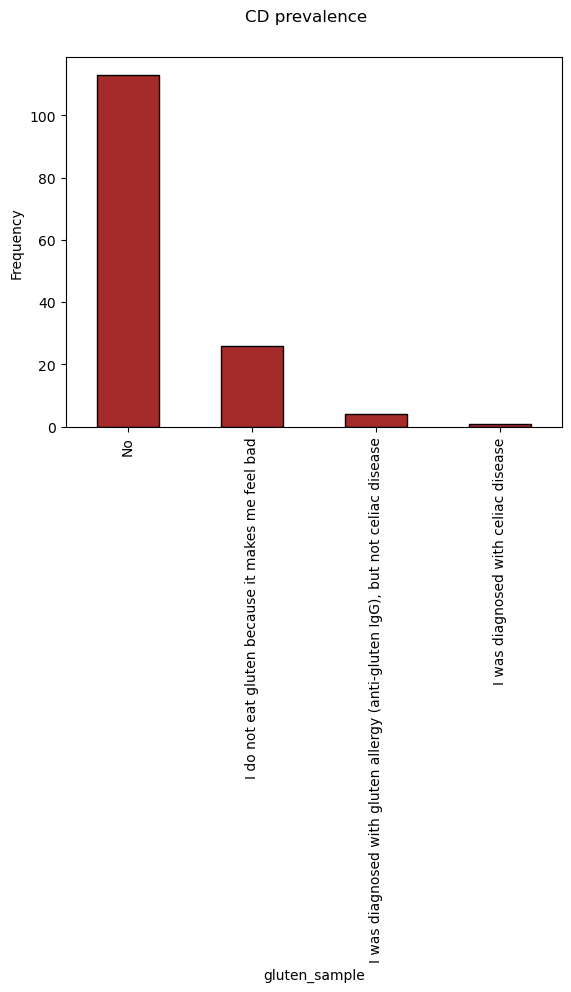

In [84]:
sample_metadata["gluten_sample"].value_counts().plot(kind="bar", edgecolor="black", color="brown")
plt.ylabel("Frequency")
plt.suptitle("CD prevalence")

### Origin - Country / industrialisation index